In [1]:
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from keras.backend import ones_like
from keras.layers.recurrent import GRU
from keras.layers.core import Lambda
from keras.optimizers import adam
from keras.layers import Conv1D, Dense, Reshape, Concatenate, Flatten, Activation, Dropout,MaxPooling1D
from keras.models import Input, Model
from keras_self_attention import SeqSelfAttention
from keras_multi_head import MultiHeadAttention
import numpy as np
import os
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.keras.backend import set_session

from keras.callbacks import EarlyStopping

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
tf.keras.backend.clear_session()  # For easy reset of notebook state.

config_proto = tf.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.Session(config=config_proto)
set_session(session)

/data/jiahao/translate/py35venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/jiahao/translate/py35venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/jiahao/translate/py35venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/jiahao/translate/py35venv/lib/python3.5/site-pack

In [2]:
from keras import backend as K
from keras.layers import Layer ,Add
from keras.layers.core import Lambda

def local_context_learning(path_length, input_length, input_dim, output_dim, hidden_dim, filters_num, kernel_val,
                           learning_rate, drop_rate):
    basic_data_input = Input(shape=(path_length, input_length, input_dim))

    basic_input = Reshape((path_length, input_length * input_dim))(basic_data_input)
    
    GRU_layer = GRU(units=hidden_dim, return_sequences=True)
    rnn_output = GRU_layer(basic_input)
    Self_1 = SeqSelfAttention(attention_activation='sigmoid')
    rnn_att = Self_1(rnn_output)
    CNN_layer_1 = Conv1D(filters=filters_num, kernel_size=kernel_val, padding="same")
    cnn_output = CNN_layer_1(basic_input)
    Dense_1 = Dense(hidden_dim)
    cnn_output_reformat = Dense_1(cnn_output)
    Self_2 = SeqSelfAttention(attention_activation='sigmoid')
    cnn_att = Self_2(cnn_output_reformat)
    Conca_1 = Concatenate(axis=1)
    new_value = Conca_1([rnn_att, cnn_att])
    new_keys = Lambda(lambda x: ones_like(x))(new_value)
    Multi_1 = MultiHeadAttention(head_num=2)
    new_result = Multi_1([basic_input, new_keys, new_value])
    result = Flatten()(new_result)
    Drop_1 = Dropout(rate=drop_rate)
    result_fix = Drop_1(result)
    Dense_2 = Dense(output_dim)
    method_vector = Dense_2(result_fix)
    method_vector = Reshape((-1, 128))(method_vector)

    CNN_layer_2 = Conv1D(filters=filters_num, kernel_size=kernel_val, padding="same")
    cnn_output_for_classification = CNN_layer_2(method_vector)
    Pool_1 = MaxPooling1D(pool_size=2, padding='same')
    pooling_output = Pool_1(cnn_output_for_classification)
    output_classification = Flatten()(pooling_output)
    Drop_2 = Dropout(rate=drop_rate)
    output_classification_fix = Drop_2(output_classification)
    Dense_3 = Dense(32, activation='relu')
    output_classification_fix = Dense_3(output_classification_fix)
    Dense_4 = Dense(16, activation='relu')
    output_classification_fix = Dense_4(output_classification_fix)
    Dense_5 = Dense(1)
    fixed_output_classification = Dense_5(output_classification_fix)
    Active_1 = Activation(activation='sigmoid')
    stand_output = Active_1(fixed_output_classification)
    model = Model(basic_data_input, stand_output)
    ada = adam(lr=learning_rate)
    model.compile(optimizer=ada, loss='binary_crossentropy', metrics=['accuracy'])

    
    New_input  = Input(shape=(path_length, input_length, input_dim))
    New_input_ = Reshape((path_length, input_length * input_dim))(New_input)
    new_test_1 = GRU_layer(New_input_)
    new_test_2 = Self_1(new_test_1)
    new_test_3 = CNN_layer_1(New_input_)
    new_test_4 = Dense_1(new_test_3)
    new_test_5 = Self_2(new_test_4)
    new_test_6 = Conca_1([new_test_2, new_test_5])
    new_test_7 = Lambda(lambda x: ones_like(x))(new_test_6)
    new_test_8 = Multi_1([New_input_, new_test_7, new_test_6])
    new_test_9 = Flatten()(new_test_8)
    new_test_10 = Drop_1(new_test_9)
    new_test_11 = Dense_2(new_test_10)
    new_test_12 = Reshape((-1, 128))(new_test_11)
    new_test_13 = CNN_layer_2(new_test_12)
    new_test_14 = Pool_1(new_test_13)
    new_test_15 = Flatten()(new_test_14)
    new_test_16 = Drop_2(new_test_15)
    new_test_17 = Dense_3(new_test_16)
    new_test_18 = Dense_4(new_test_17)
    new_test_19 = Dense_5(new_test_18)
    new_test_20 = Active_1(new_test_19)
    model_test = Model(New_input, new_test_20)
    return model, model_test

In [3]:
model_local, model_local_test = local_context_learning(15, 20, 128, 128, 128, 64, 3, 0.0001, 0.5)
model_local.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 15, 20, 128)  0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 15, 2560)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 15, 64)       491584      reshape_1[0][0]                  
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 15, 128)      1032576     reshape_1[0][0]                

In [4]:
def getting_data(file_path, print_text):
    print("Loading " + print_text + " Data...")
    data = np.load(file_path,allow_pickle = True)
    print("Done")
    return data

In [5]:
input_data = getting_data("./data/local_train_input_combine.npy", "Input")
label_data = getting_data("./data/local_train_label_combine.npy", "Label")
output_data = getting_data("./data/local_train_output_combine.npy", "Output")
label_data.shape=(-1,15)

Loading Input Data...
Done
Loading Label Data...
Done
Loading Output Data...
Done


In [6]:
label_data.shape

(7151, 15)

In [7]:
label_data = np.zeros((7151, 15))

In [8]:
v_input_data = getting_data("./data/local_val_input_combine.npy", "Input")
v_label_data = getting_data("./data/local_val_label_combine.npy", "Label")
v_output_data = getting_data("./data/local_val_output_combine.npy", "Output")
v_label_data.shape=(-1,15)

Loading Input Data...
Done
Loading Label Data...
Done
Loading Output Data...
Done


In [9]:
v_label_data.shape

(2388, 15)

In [10]:
v_label_data = np.zeros((2388, 15))

In [11]:
print("Training Local Context Model...")
model_local.fit(input_data, output_data, batch_size=256, epochs=100,validation_data=(v_input_data, v_output_data))

Training Local Context Model...

Train on 7151 samples, validate on 2388 samples
Epoch 1/100
7151/7151 [==============================] - 9s 1ms/step - loss: 0.6926 - accuracy: 0.5327 - val_loss: 0.6896 - val_accuracy: 0.5360
Epoch 2/100
7151/7151 [==============================] - 7s 1ms/step - loss: 0.6842 - accuracy: 0.5641 - val_loss: 0.6679 - val_accuracy: 0.6160
Epoch 3/100
7151/7151 [==============================] - 7s 979us/step - loss: 0.6616 - accuracy: 0.6069 - val_loss: 0.6432 - val_accuracy: 0.6386
Epoch 4/100
7151/7151 [==============================] - 7s 988us/step - loss: 0.6458 - accuracy: 0.6343 - val_loss: 0.6406 - val_accuracy: 0.6415
Epoch 5/100
7151/7151 [==============================] - 7s 994us/step - loss: 0.6384 - accuracy: 0.6504 - val_loss: 0.6383 - val_accuracy: 0.6327
Epoch 6/100
7151/7151 [==============================] - 7s 1ms/step - loss: 0.6338 - accuracy: 0.6479 - val_loss: 0.6267 - val_accuracy: 0.6528
Epoch 7/100
7151/7151 [====================

7151/7151 [==============================] - 8s 1ms/step - loss: 0.3300 - accuracy: 0.8491 - val_loss: 0.9015 - val_accuracy: 0.7014
Epoch 55/100
7151/7151 [==============================] - 9s 1ms/step - loss: 0.3071 - accuracy: 0.8596 - val_loss: 0.9832 - val_accuracy: 0.6893
Epoch 56/100
7151/7151 [==============================] - 9s 1ms/step - loss: 0.3273 - accuracy: 0.8472 - val_loss: 1.0531 - val_accuracy: 0.6855
Epoch 57/100
7151/7151 [==============================] - 9s 1ms/step - loss: 0.3078 - accuracy: 0.8547 - val_loss: 0.9421 - val_accuracy: 0.6822
Epoch 58/100
7151/7151 [==============================] - 9s 1ms/step - loss: 0.2936 - accuracy: 0.8630 - val_loss: 0.9946 - val_accuracy: 0.6905
Epoch 59/100
7151/7151 [==============================] - 9s 1ms/step - loss: 0.2857 - accuracy: 0.8666 - val_loss: 1.0131 - val_accuracy: 0.6947
Epoch 60/100
7151/7151 [==============================] - 9s 1ms/step - loss: 0.3010 - accuracy: 0.8617 - val_loss: 1.0502 - val_accuracy

In [12]:
model_local.save('model_combine_train.h5')
model_local_test.save('model_combine_test.h5')

In [13]:
t_input_data = getting_data("./data/local_test_input_combine.npy", "Input")
t_output_data = getting_data("./data/local_test_output_combine.npy", "Output")

Loading Input Data...
Done
Loading Output Data...
Done


In [14]:
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [15]:
y_predict = model_local_test.predict(t_input_data)

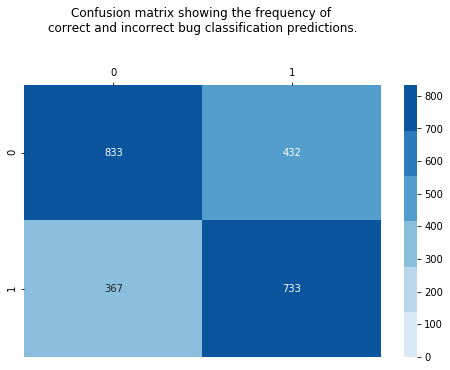

In [16]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(t_output_data, np.rint(y_predict)),
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(8, 5)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [17]:
from sklearn.metrics import  auc, roc_curve, precision_recall_curve, matthews_corrcoef, f1_score, roc_auc_score
fpr_keras, tpr_keras, thresholds_keras = roc_curve(t_output_data, y_predict)
precision, recall, thresholds = precision_recall_curve(t_output_data, y_predict)

In [18]:
import matplotlib.pyplot as plt

auc_keras = auc(fpr_keras, tpr_keras)
roc_auc = roc_auc_score(t_output_data, y_predict)
pr_auc = auc(recall, precision)
f1 = f1_score(t_output_data, np.rint(y_predict))
mcc = matthews_corrcoef(t_output_data, np.rint(y_predict))

In [19]:
print('PR AUC: %.3f' % pr_auc)
print('ROC AUC: %.3f' % roc_auc)
print('MCC: %.3f' % mcc)
print('F1: %.3f' % f1)

PR AUC: 0.697
ROC AUC: 0.715
MCC: 0.324
F1: 0.647


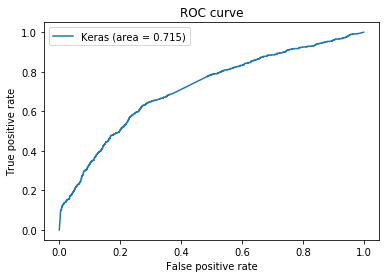

In [20]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [21]:
tn, fp, fn, tp = metrics.confusion_matrix(
    t_output_data.astype(int), 
    np.rint(y_predict)
).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)
r = tp/(tp+fn)
p = tp/(tp+fp)
f = (2*p*r)/(p+r)
acc = (tp+tn)/(tp+fp+fn+tn)

In [22]:
print("fpr_nn",fpr_nn)
print("fnr_nn",fnr_nn)
print("r",r)
print("p",p)
print("f",f)
print("acc",acc)

fpr_nn 0.3708154506437768
fnr_nn 0.30583333333333335
r 0.6663636363636364
p 0.6291845493562231
f 0.6472406181015452
acc 0.6621564482029598


In [23]:
best_f1 = 0
for predict in y_predict:
    predict_after_threshold = np.int64(y_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if f>best_f1:
        best_f1 = f
        print(r,p,f,acc,predict)

0.6881818181818182 0.6174551386623165 0.6509028374892519 0.6566596194503171 [0.39142323]
0.8654545454545455 0.5357343837929094 0.6618004866180048 0.588583509513742 [0.04893702]
0.8427272727272728 0.5456150676868746 0.662379421221865 0.6004228329809725 [0.0775069]
0.8172727272727273 0.5573465592064476 0.6627349797272393 0.6131078224101479 [0.15370578]
0.7809090909090909 0.5792312879298719 0.6651180797522261 0.6342494714587738 [0.34369665]
0.7772727272727272 0.5816326530612245 0.6653696498054474 0.6363636363636364 [0.3738847]
0.7854545454545454 0.5775401069518716 0.6656394453004623 0.6329809725158563 [0.31171745]
0.7836363636363637 0.5789120214909335 0.6658941676322905 0.6342494714587738 [0.32762176]
0.7827272727272727 0.5797979797979798 0.6661508704061896 0.6350951374207188 [0.33876258]


In [24]:
best_r = 0
for predict in y_predict:
    predict_after_threshold = np.int64(y_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if r>best_r:
        best_r = r
        print(r,p,f,acc,predict)

0.6881818181818182 0.6174551386623165 0.6509028374892519 0.6566596194503171 [0.39142323]
0.8654545454545455 0.5357343837929094 0.6618004866180048 0.588583509513742 [0.04893702]
0.9218181818181819 0.5039761431411531 0.6516709511568124 0.5416490486257928 [0.00316504]
0.94 0.49191246431969554 0.6458463460337289 0.5205073995771671 [0.00079352]
0.9409090909090909 0.4907539118065434 0.6450607665939545 0.5183932346723045 [0.00071621]
0.9881818181818182 0.47322594688724423 0.6399764498086546 0.4828752642706131 [1.4007092e-06]
0.99 0.4714285714285714 0.6387096774193549 0.4790697674418605 [5.066395e-07]
0.9927272727272727 0.46806686669524217 0.6361782697349257 0.4718816067653277 [0.]


In [25]:
best_a = 0
for predict in y_predict:
    predict_after_threshold = np.int64(y_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if acc>best_a:
        best_a = acc
        print(r,p,f,acc,predict)

0.6881818181818182 0.6174551386623165 0.6509028374892519 0.6566596194503171 [0.39142323]
0.6472727272727272 0.656221198156682 0.6517162471395881 0.6782241014799154 [0.6366209]
0.639090909090909 0.6600938967136151 0.6494226327944572 0.6790697674418604 [0.6807126]
0.6236363636363637 0.6666666666666666 0.6444340065758573 0.6799154334038054 [0.7333102]
0.6263636363636363 0.6663442940038685 0.6457357075913777 0.680338266384778 [0.73074883]
0.6290909090909091 0.6666666666666666 0.64733395696913 0.681183932346723 [0.7243991]
0.6290909090909091 0.6673095467695275 0.6476368741226017 0.6816067653276956 [0.7284264]


# imbalance testing

In [26]:
im_t_input_data = getting_data("./data/local_im_test_input_combine.npy", "Input")
im_t_output_data = getting_data("./data/local_im_test_output_combine.npy", "Output")

Loading Input Data...
Done
Loading Output Data...
Done


In [27]:
y_im_predict = model_local_test.predict(im_t_input_data)

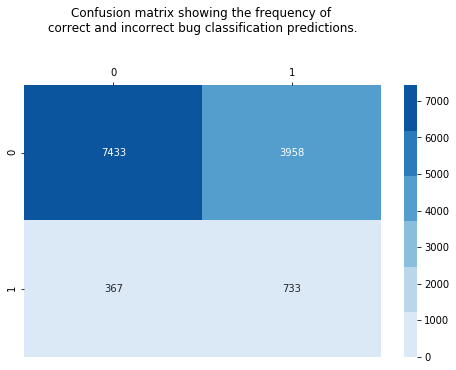

In [28]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(im_t_output_data, np.rint(y_im_predict)),
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(8, 5)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [29]:
tn, fp, fn, tp = metrics.confusion_matrix(
    im_t_output_data.astype(int), 
    np.rint(y_im_predict)
).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)
r = tp/(tp+fn)
p = tp/(tp+fp)
f = (2*p*r)/(p+r)
acc = (tp+tn)/(tp+fp+fn+tn)

In [30]:
print("fpr_nn",fpr_nn)
print("fnr_nn",fnr_nn)
print("r",r)
print("p",p)
print("f",f)
print("acc",acc)

fpr_nn 0.8437433383073971
fnr_nn 0.04705128205128205
r 0.6663636363636364
p 0.15625666169260286
f 0.2531514418925919
acc 0.6537507005043631


In [31]:
best_f1 = 0
for predict in y_im_predict:
    predict_after_threshold = np.int64(y_im_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        im_t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if f>best_f1:
        best_f1 = f
        print(r,p,f,acc,predict)

0.6672727272727272 0.15623669646658153 0.25319075543290787 0.6533504122968538 [0.4968942]
0.49 0.2058037418862161 0.28986286636192526 0.7885677687935313 [0.9299507]
0.49 0.2064343163538874 0.2904877391538669 0.7892082299255464 [0.93033767]
0.4290909090909091 0.2268140317155214 0.29676202452059103 0.8209110559602915 [0.97176915]
0.44545454545454544 0.2246675836772123 0.298689423956111 0.815787366904171 [0.96509635]
0.44545454545454544 0.22487379531895366 0.29887160719731626 0.8159474821871747 [0.96520567]
0.44272727272727275 0.22567191844300277 0.29895641497851444 0.8171483468097029 [0.9666243]


In [32]:
best_a = 0
for predict in y_im_predict:
    predict_after_threshold = np.int64(y_im_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        im_t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if acc>best_a:
        best_a = acc
        print(r,p,f,acc,predict)

0.6672727272727272 0.15623669646658153 0.25319075543290787 0.6533504122968538 [0.4968942]
0.1390909090909091 0.3740831295843521 0.20278330019880716 0.9036906572732367 [0.999951]
0.07545454545454545 0.6014492753623188 0.13408723747980614 0.9141782083099832 [0.9999998]
0.06454545454545454 0.6339285714285714 0.11716171617161715 0.914338323592987 [0.99999994]


In [33]:
best_r = 0
for predict in y_im_predict:
    predict_after_threshold = np.int64(y_im_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        im_t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if r>best_r:
        best_r = r
        print(r,p,f,acc,predict)

0.6672727272727272 0.15623669646658153 0.25319075543290787 0.6533504122968538 [0.4968942]
0.9763636363636363 0.09065586224360597 0.16590715995983626 0.13545752942118325 [5.9604645e-06]
0.9927272727272727 0.08903383611903791 0.16341189674523007 0.10487551036746458 [2.9802322e-08]
